In [ ]:
#!pip install tensorflow==2.0

Reproduced with code from this excellent [blog](https://towardsdatascience.com/faster-r-cnn-object-detection-implemented-by-keras-for-custom-data-from-googles-open-images-125f62b9141a)

In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from skimage import io
from shutil import copyfile
import sys
import time

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
tf.__version__

'2.8.2'

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = '/content/gdrive/MyDrive/MDP/1.0'

### Load data from .csv file

* `train-images-boxable.csv` file contains the image name and image url
* `train-annotations-bbox.csv` file contains the bounding box info with the image id (name) and the image label name
* `class-descriptions-boxable.csv` file contains the image label name corresponding to its class name

Download link:

https://storage.googleapis.com/openimages/web/download.html

https://www.figure-eight.com/dataset/open-images-annotated-with-bounding-boxes/

In [ ]:
!wget https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv

--2022-08-28 17:00:06--  https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.145.128, 209.85.146.128, 209.85.147.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1194033454 (1.1G) [text/csv]
Saving to: ‘train-annotations-bbox.csv’

train-annotations-b 100%[===================>]   1.11G   213MB/s    in 5.7s    

2022-08-28 17:00:12 (199 MB/s) - ‘train-annotations-bbox.csv’ saved [1194033454/1194033454]



In [ ]:
!wget https://storage.googleapis.com/openimages/2018_04/train/train-images-boxable-with-rotation.csv

--2022-08-28 17:00:12--  https://storage.googleapis.com/openimages/2018_04/train/train-images-boxable-with-rotation.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.145.128, 209.85.146.128, 209.85.147.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 638407721 (609M) [text/csv]
Saving to: ‘train-images-boxable-with-rotation.csv’

train-images-boxabl 100%[===================>] 608.83M   204MB/s    in 3.0s    

2022-08-28 17:00:15 (204 MB/s) - ‘train-images-boxable-with-rotation.csv’ saved [638407721/638407721]



The original code used "***train-images-boxable.csv***" but I couldn't find it. So, I am using "***train-images-boxable-with-rotations.csv"***

In [ ]:
!wget https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv

--2022-08-28 17:00:16--  https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.145.128, 209.85.146.128, 209.85.147.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12011 (12K) [text/csv]
Saving to: ‘class-descriptions-boxable.csv’

class-descriptions- 100%[===================>]  11.73K  --.-KB/s    in 0s      

2022-08-28 17:00:16 (86.6 MB/s) - ‘class-descriptions-boxable.csv’ saved [12011/12011]



In [ ]:
images_boxable_fname = 'train-images-boxable-with-rotation.csv'
annotations_bbox_fname = 'train-annotations-bbox.csv'
class_descriptions_fname = 'class-descriptions-boxable.csv'

In [ ]:
images_boxable = pd.read_csv(images_boxable_fname)
images_boxable.head()

,ImageID,Subset,OriginalURL,OriginalLandingURL,License,AuthorProfileURL,Author,Title,OriginalSize,OriginalMD5,Thumbnail300KURL,Rotation
0,4fa8054781a4c382,train,https://farm3.staticflickr.com/5310/5898076654...,https://www.flickr.com/photos/michael-beat/589...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/michael-beat/,Michael Beat,...die FNF-Kerze,4405052,KFukvivpCM5QXl5SqKe41g==,https://c1.staticflickr.com/6/5310/5898076654_...,0.0
1,b37f763ae67d0888,train,https://c1.staticflickr.com/1/67/197493648_628...,https://www.flickr.com/photos/drstarbuck/19749...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/drstarbuck/,Karen,Three boys on a hill,494555,9IzEn38GRNsVpATuv7gzEA==,https://c3.staticflickr.com/1/67/197493648_628...,0.0
2,7e8584b0f487cb9e,train,https://c7.staticflickr.com/8/7056/7143870979_...,https://www.flickr.com/photos/circasassy/71438...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/circasassy/,CircaSassy,A Christmas carol and The cricket on the heart...,2371584,3hQwu0iSzY1VIoXiwp0/Mg==,https://c7.staticflickr.com/8/7056/7143870979_...,0.0
3,86638230febe21c4,train,https://farm5.staticflickr.com/5128/5301868579...,https://www.flickr.com/photos/ajcreencia/53018...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/ajcreencia/,Alex,Abbey and Kenny,949267,onB+rCZnGQg5PRX7xOs18Q==,https://c4.staticflickr.com/6/5128/5301868579_...,NaN
4,249086e72671397d,train,https://c6.staticflickr.com/4/3930/15342460029...,https://www.flickr.com/photos/codnewsroom/1534...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/codnewsroom/,COD Newsroom,Suburban Law Enforcement Academy 20th Annivers...,6541758,MjpaAVbMAWbCusSaxI1D7w==,https://c1.staticflickr.com/4/3930/15342460029...,0.0


In [ ]:
annotations_bbox = pd.read_csv(annotations_bbox_fname)
annotations_bbox.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,0,0,0
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,0,0,0
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,0,0,0
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,0,0,0
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,0,0,0


1. **XMin, XMax, YMin, YMax**: coordinates of the box, in normalized image coordinates.
2. **IsOccluded**: Indicates that the object is occluded by another object in the image.
3. **IsTruncated**: Indicates that the object extends beyond the boundary of the image.
4. **IsGroupOf**: Indicates that the box spans a group of objects (e.g., a bed of flowers or a crowd of people). We asked annotators to use this tag for cases with more than 5 instances which are heavily occluding each other and are physically touching.
5. **IsDepiction**: Indicates that the object is a depiction (e.g., a cartoon or drawing of the object, not a real physical instance).
6. **IsInside**: Indicates a picture taken from the inside of the object (e.g., a car interior or inside of a building).


In [ ]:
class_descriptions = pd.read_csv(class_descriptions_fname, header=None)
class_descriptions.head()

,0,1
0,/m/011k07,Tortoise
1,/m/011q46kg,Container
2,/m/012074,Magpie
3,/m/0120dh,Sea turtle
4,/m/01226z,Football


### Plot Bounding box

In [ ]:
def plot_bbox(img_id):
  img_url = images_boxable.loc[images_boxable["ImageID"]==img_id]['OriginalURL'].values[0]
  img = io.imread(img_url)
  height, width, channel = img.shape
  print(f"Image: {img.shape}")
  bboxs = annotations_bbox[annotations_bbox['ImageID']==img_id]
  for index, row in bboxs.iterrows():
      xmin = row['XMin']
      xmax = row['XMax']
      ymin = row['YMin']
      ymax = row['YMax']
      xmin = int(xmin*width)
      xmax = int(xmax*width)
      ymin = int(ymin*height)
      ymax = int(ymax*height)
      label_name = row['LabelName']
      class_series = class_descriptions[class_descriptions[0]==label_name]
      class_name = class_series[1].values[0]
      print(f"Coordinates: {xmin,ymin}, {xmax,ymax}")
      cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (255,0,0), 5)
      font = cv2.FONT_HERSHEY_SIMPLEX
      cv2.putText(img, class_name, (xmin,ymin-10), font, 3, (0,255,0), 5)
  plt.figure(figsize=(15,10))
  plt.title('Image with Bounding Box')
  plt.imshow(img)
  plt.axis("off")
  plt.show()

Finding images with lesser number of objects so as easy to visualize

In [ ]:
least_objects_img_ids = annotations_bbox["ImageID"].value_counts().tail(80).index.values

Image: (3072, 2304, 3)
Coordinates: (79, 0), (2302, 3069)
Image: (3508, 2480, 3)
Coordinates: (359, 1179), (2192, 3233)


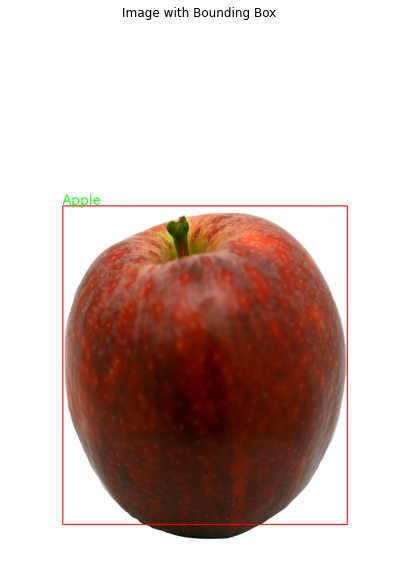

Image: (3056, 4592, 3)
Coordinates: (0, 0), (4587, 2645)
Image: (1536, 2048, 3)
Coordinates: (55, 90), (1172, 1528)


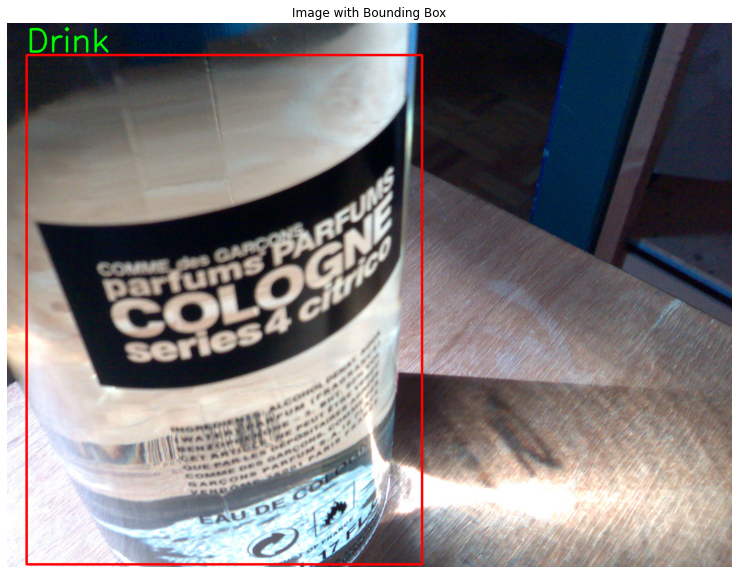

Image: (2672, 4000, 3)
Coordinates: (302, 100), (1667, 1403)


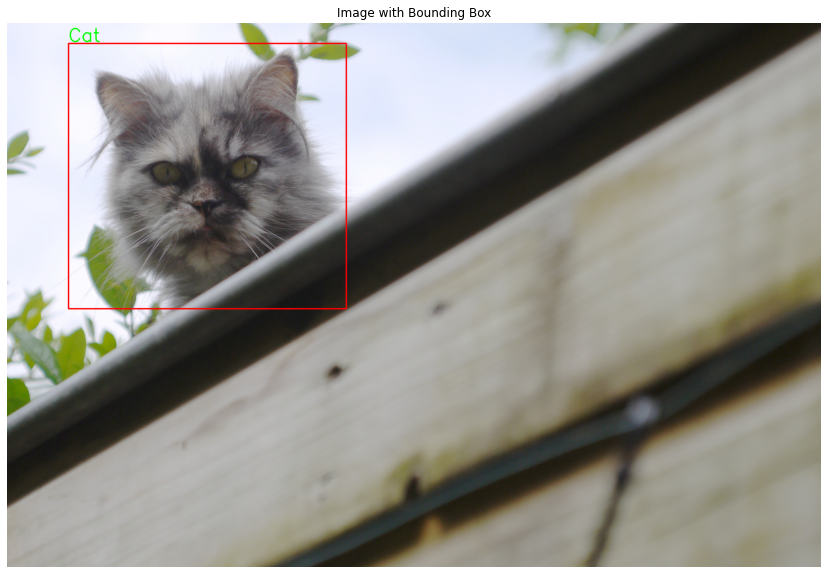

In [ ]:
for img_id in random.sample(list(least_objects_img_ids), 5):
  try:
    plot_bbox(img_id)
  except Exception as e:
    continue

### Get subset of the whole dataset

In [ ]:
class_descriptions.loc[class_descriptions[1].isin(['Person', 'Car', 'Sculpture'])]

,0,1
68,/m/01g317,Person
358,/m/06msq,Sculpture
570,/m/0k4j,Car


In [ ]:
person_pd = class_descriptions[class_descriptions[1]=='Person']
car_pd = class_descriptions[class_descriptions[1]=='Car']
sculpture_pd = class_descriptions[class_descriptions[1]=='Sculpture']

label_name_person = person_pd[0].values[0]
label_name_car = car_pd[0].values[0]
label_name_sculpture = sculpture_pd[0].values[0]

In [ ]:
person_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_person]
car_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_car]
sculpture_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_sculpture]

In [ ]:
print('There are %d persons in the dataset' %(len(person_bbox)))
print('There are %d cars in the dataset' %(len(car_bbox)))
print('There are %d sculptures in the dataset' %(len(sculpture_bbox)))

person_img_id = person_bbox['ImageID']
car_img_id = car_bbox['ImageID']
sculpture_img_id = sculpture_bbox['ImageID']

There are 1034721 persons in the dataset
There are 248075 cars in the dataset
There are 34533 sculptures in the dataset


In [ ]:
person_img_id = np.unique(person_img_id)
car_img_id = np.unique(car_img_id)
sculpture_img_id = np.unique(sculpture_img_id)

print('There are %d images which contain persons' % (len(person_img_id)))
print('There are %d images which contain cars' % (len(car_img_id)))
print('There are %d images which contain sculptures' % (len(sculpture_img_id)))

There are 248384 images which contain persons
There are 89465 images which contain cars
There are 18107 images which contain sculptures


In [ ]:
n = 5000
subperson_img_id = random.sample(list(person_img_id), n)
subcar_img_id = random.sample(list(car_img_id), n)
subsculpture_img_id = random.sample(list(sculpture_img_id), n)

In [ ]:
subperson_pd = images_boxable.loc[images_boxable['ImageID'].isin(subperson_img_id)]
subcar_pd = images_boxable.loc[images_boxable['ImageID'].isin(subcar_img_id)]
subsculpture_pd = images_boxable.loc[images_boxable['ImageID'].isin(subsculpture_img_id)]

In [ ]:
subperson_pd.shape

(5000, 12)

In [ ]:
subperson_pd.head()

,ImageID,Subset,OriginalURL,OriginalLandingURL,License,AuthorProfileURL,Author,Title,OriginalSize,OriginalMD5,Thumbnail300KURL,Rotation
200,4791ccd959bf31ae,train,https://c7.staticflickr.com/9/8163/7507623812_...,https://www.flickr.com/photos/mattpaish/750762...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/mattpaish/,Matt Paish,A sulphur miner walks to the crater at Kawah I...,754107,mmXw49nGjO5m90SVXg69YA==,https://c3.staticflickr.com/9/8163/7507623812_...,NaN
420,8b83da18a353e207,train,https://farm8.staticflickr.com/2931/1404003603...,https://www.flickr.com/photos/107803477@N08/14...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/107803477@N08/,btphotosbduk,BDUK Cumbria St Bees pole7,2967857,2eZP/76+TNScYLVWil8vgw==,https://c3.staticflickr.com/3/2931/14040036036...,0.0
1903,e1512d63cbf56d05,train,https://farm6.staticflickr.com/7274/7736377518...,https://www.flickr.com/photos/eltb/7736377518,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/eltb/,Enrique López-Tamayo Biosca,"Templo San Francisco de Asís,Santander,Cantabr...",651856,TqMeODWqTlNDrLFRTSHqcA==,https://c6.staticflickr.com/8/7274/7736377518_...,NaN
2290,ad37a068f1213cdd,train,https://c6.staticflickr.com/9/8302/7914103220_...,https://www.flickr.com/photos/eulinky/7914103220,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/eulinky/,Eulinky,Schweden 2012,3951718,NODz95Z9YWOopDXDz29waA==,https://c1.staticflickr.com/9/8302/7914103220_...,0.0
2529,766d91cb056dd2c2,train,https://farm3.staticflickr.com/3632/3432667889...,https://www.flickr.com/photos/abbybatchelder/3...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/abbybatchelder/,Abigail Batchelder,IMG_0116,2809144,wWtrXqyferObSD7MPkjhvw==,https://c7.staticflickr.com/4/3632/3432667889_...,0.0


In [ ]:
subperson_dict = subperson_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()
subcar_dict = subcar_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()
subsculpture_dict = subsculpture_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()

In [ ]:
mappings = [subperson_dict, subcar_dict, subsculpture_dict]

In [ ]:
len(mappings)

3

In [ ]:
len(mappings[0])

5000

In [ ]:
classes = ['Person', 'Car', 'Sculpture']

### Download images

We need to save the images with filename as `image id` with jpg extension

In [ ]:
# download images
for idx, obj_type in enumerate(classes):
  if obj_type == 'Person':
    continue
  n_issues = 0
  # create the directory
  path2 = path + '/' + obj_type
  if os.path.exists(path2):
    continue
  else:
    os.mkdir(path2)
  for img_id, url in mappings[idx].items():
    try:
      img = io.imread(url)
      saved_path = os.path.join(path2, img_id+".jpg")
      io.imsave(saved_path, img)
    except Exception as e:
      n_issues += 1
  print(f"Images Issues: {n_issues}")

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7496 bytes but only got 6624. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/JpegImagePlugin.py:793: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 12. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


Images Issues: 516


In [ ]:
!ls '/content/gdrive/MyDrive/MDP/1.0/Person' | wc -l

4458


In [ ]:
!ls '/content/gdrive/MyDrive/MDP/1.0/Car' | wc -l

2453


In [ ]:
!ls '/content/gdrive/MyDrive/MDP/1.0/Sculpture' | wc -l

4484


In [ ]:
n = 2400

### Dataset format for Faster-RCNN code

(fname_path, xmin, xmax, ymin, ymax, class_name)

train: 0.8
validation: 0.2

In [ ]:
# save images to train and test directory
train_path = path+'/train'
test_path = path+'/test'

In [ ]:
if not os.path.exists('/content/gdrive/MyDrive/MDP/1.0/train'):
  os.mkdir('/content/gdrive/MyDrive/MDP/1.0/train')
if not os.path.exists('/content/gdrive/MyDrive/MDP/1.0/test'):
  os.mkdir('/content/gdrive/MyDrive/MDP/1.0/test')

In [ ]:
random.seed(1)

In [ ]:
for i in range(len(classes)):
    all_imgs = os.listdir(path+'/'+classes[i])
    all_imgs = [f for f in all_imgs if not f.startswith('.')]
    random.shuffle(all_imgs)
    
    limit = int(n*0.8)

    train_imgs = all_imgs[:limit]
    test_imgs = all_imgs[limit:]
    
    # copy each classes' images to train directory
    for j in range(len(train_imgs)):
        original_path = os.path.join(path+'/'+classes[i], train_imgs[j])
        new_path = os.path.join(train_path, train_imgs[j])
        copyfile(original_path, new_path)
    
    # copy each classes' images to test directory
    for j in range(len(test_imgs)):
        original_path = os.path.join(path+'/'+classes[i], test_imgs[j])
        new_path = os.path.join(test_path, test_imgs[j])
        copyfile(original_path, new_path)

In [ ]:
!ls '/content/gdrive/MyDrive/MDP/1.0/train' | wc -l

5753


In [ ]:
!ls '/content/gdrive/MyDrive/MDP/1.0/test' | wc -l

5625


In [ ]:
label_names = [label_name_person, label_name_car, label_name_sculpture]

train_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# Find boxes in each image and put them in a dataframe
train_imgs = os.listdir(train_path)
train_imgs = [name for name in train_imgs if not name.startswith('.')]

for i in range(len(train_imgs)):
  if i%100 == 0:
    print(i)
  sys.stdout.write('Parse train_imgs ' + str(i) + '; Number of boxes: ' + str(len(train_df)) + '\r')
  sys.stdout.flush()
  img_name = train_imgs[i]
  img_id = img_name[0:16]
  tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
  for index, row in tmp_df.iterrows():
      labelName = row['LabelName']
      for i in range(len(label_names)):
          if labelName == label_names[i]:
              train_df = train_df.append({'FileName': img_name, 
                                          'XMin': row['XMin'], 
                                          'XMax': row['XMax'], 
                                          'YMin': row['YMin'], 
                                          'YMax': row['YMax'], 
                                          'ClassName': classes[i]}, 
                                         ignore_index=True)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900


In [ ]:
train_df.head()

,FileName,XMin,XMax,YMin,YMax,ClassName
0,1c1ae557130cb938.jpg,0.000000,0.357500,0.000000,0.999167,Tree
1,1c1ae557130cb938.jpg,0.385625,0.716250,0.485833,0.672500,Tree
2,1c1ae557130cb938.jpg,0.747500,0.999375,0.443333,0.906667,Tree
3,1c1ae557130cb938.jpg,0.411875,0.558125,0.661667,0.740833,Car
4,1c1ae557130cb938.jpg,0.498750,0.589375,0.650833,0.691667,Car


In [ ]:
train_df.shape

(42833, 6)

In [ ]:
train_df.to_csv('train.csv')

In [ ]:
val_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# find boxes in each image and put them in a dataframe
test_imgs = os.listdir(test_path)
test_imgs = [name for name in test_imgs if not name.startswith('.')]

for i in range(len(test_imgs)):
  if i%100==0:
    print(i)
  sys.stdout.write('Parse test_imgs ' + str(i) + '; Number of boxes: ' + str(len(val_df)) + '\r')
  sys.stdout.flush()
  img_name = test_imgs[i]
  img_id = img_name[0:16]
  tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
  for index, row in tmp_df.iterrows():
      labelName = row['LabelName']
      for i in range(len(label_names)):
          if labelName == label_names[i]:
              val_df = val_df.append({'FileName': img_name, 
                                          'XMin': row['XMin'], 
                                          'XMax': row['XMax'], 
                                          'YMin': row['YMin'], 
                                          'YMax': row['YMax'], 
                                          'ClassName': classes[i]}, 
                                         ignore_index=True)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400


In [ ]:
val_df.shape

(25024, 6)

In [ ]:
val_df.to_csv('test.csv')

### Write train.csv to annotation.txt

In [ ]:
train_df = pd.read_csv('/content/train 2.0.csv')

# for training
with open(path +"/annotation 2.0.txt", "w+") as f:
  for idx, row in train_df.iterrows():
    img = cv2.imread(train_path + '/' + row['FileName'])
    height, width = img.shape[:2]
    x1 = int(row['XMin'] * width)
    x2 = int(row['XMax'] * width)
    y1 = int(row['YMin'] * height)
    y2 = int(row['YMax'] * height)
    fileName = os.path.join(train_path, row['FileName'])
    className = row['ClassName']
    f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')

In [ ]:
test_df = pd.read_csv('/content/test 2.0.csv')

# for test
with open(path + "/test_annotation 2.0.txt", "w+") as f:
  for idx, row in test_df.iterrows():
      sys.stdout.write(str(idx) + '\r')
      sys.stdout.flush()
      img = cv2.imread(test_path + '/' + row['FileName'])
      height, width = img.shape[:2]
      x1 = int(row['XMin'] * width)
      x2 = int(row['XMax'] * width)
      y1 = int(row['YMin'] * height)
      y2 = int(row['YMax'] * height)
      fileName = os.path.join(test_path, row['FileName'])
      className = row['ClassName']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')